# Kalman filter


$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> EE370: Software lab, Kyung Hee University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@khu.ac.kr) </div>_


A discrete-time linear dynamical system consists of a sequence of state vectors $x_t \in \R^n$, indexed by time $t\in \{0,\dots,N-1\}$ and dynamics equations

<br>

$$
\begin{aligned}
  x_{t+1} &= Ax_t + Bw_t \\
  y_{t} &= Cx_t + n_t   
\end{aligned}
$$

<br>

where $w_t\in\R^m$ is an disturbance input to the dynamical system (say, a wind force acting on a drone), $y_t\in\R^r$ is a  measurement vector, $n_t\in\R^r$ is the measurement noise, $A$ is the drift matrix, $B$ is the input matrix, and $C$ is the observation matrix. Note that the state variable $x_t$ for $t=0,\dots,N$ is not available to us. 

The goal of this problem is to estimate $x_t$ for $t=0,\dots,N−1$, given $A$, $B$, $C$, and $y_t$ for $t=0,\dots,N$.

<br>

Throughout this problem, we will consider a one dimensional vehicle tracking problem with state $x_t=(p_t, v_t)\in\R^2$, where the states are the position, $p_t$, and the velocity, $v_t$, of the vehicle. The vehicle is influenced by an unknown disturbance force $w_t$, and we observe noisy measurements of the vehicle's position, $y_t\in\R$.

Then the following matrices describe the above dynamics.

<br>

$$
A = \bmat{
1 & \left(1-0.5\gamma\Delta t\right)\Delta t \\
0 & 1-\gamma\Delta t 
} \\
B = \bmat{
0.5\Delta t^2 \\
\Delta t
} \\
C = \bmat{1 & 0 }
$$

<br>

We further assume that the two noise components, $w_t$ and $n_t$, both are independent and identically distributed (IID) standard normal random variables. In other words, $w_t \sim \mathcal{N}(0,1)$ and $n_t \sim \mathcal{N}(0,1)$.

<br>

The following simulates the above for $0\le t \le 50$ with $\Delta t=0.05$ and $\gamma=0.05$.


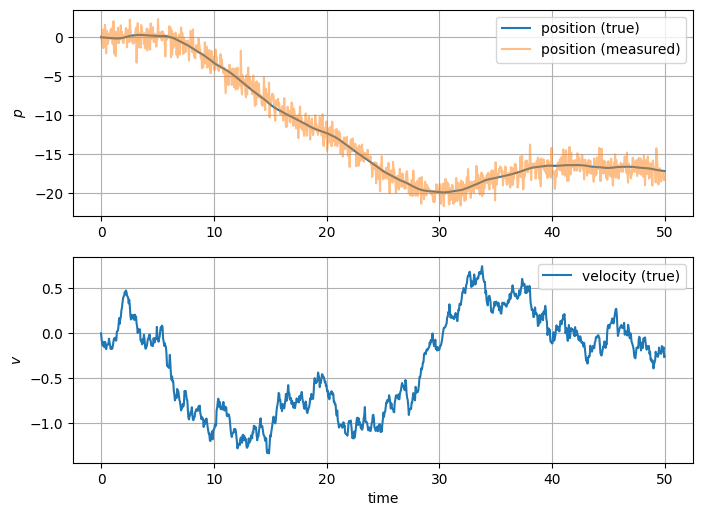

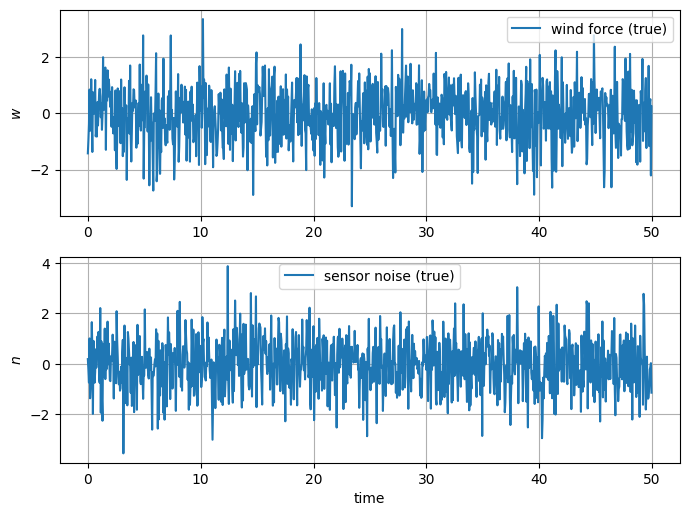

In [0]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = .05 # damping, 0 is no damping

A = np.zeros((2,2))
B = np.zeros((2,1))
C = np.zeros((1,2))

A[0,0] = 1
A[0,1] = (1-gamma*delt/2)*delt
A[1,1] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,0] = delt

C[0,0] = 1

np.random.seed(370)

x = np.zeros((2,N+1))
x[:,0] = [0,0]
y = np.zeros((1,N))

w = np.random.randn(1,N)
n = np.random.randn(1,N)

for t in range(N):
    y[:,t] = C.dot(x[:,t]) + n[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])
    
x_true = x.copy()
w_true = w.copy()
n_true = n.copy()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], label='position (true)')
plt.plot(ts[:-1],y[0,:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[:-1],w_true[0,:], label='wind force (true)')
plt.ylabel(r"$w$")
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts[:-1],n_true[0,:], label='sensor noise (true)')
plt.xlabel('time')
plt.ylabel(r'$n$')
plt.legend()
plt.grid()
plt.show()

So the problem is now to estimate $x_t = (p_t, v_t)$ with the given position measurement, $y_t$. We use the hat notation to denote the estimates. For example,

<br>


$$
  \hat{x}_t = (\hat{p}_t, \hat{v}_t)
$$

<br>

is the position and velocity estimates.

<br>

**(Problem 1)**
A very naive approach to compute the above state estimates is as follows. 

1) Since the position ($p_t$) was measured by $y_t$, we believe our measurement entirely. In other words, we let 

<br>

$$
\hat{p}^{\text{naive}}_t = y_t
$$

<br>

2) Since we don't have direct measurements on the velocity ($v_t$), we numerically differentiate $\hat{p}^{\text{naive}}_t$ to compute $\hat{v}^{\text{naive}}_t$. In other words, we let

<br>

$$
  \hat{v}^{\text{naive}}_t = \frac{\hat{p}^{\text{naive}}_t - \hat{p}^{\text{naive}}_{t-1}}{\Delta t} = \frac{y_t-y_{t-1}}{\Delta t}
$$

<br>

Implement this, and compare the state estimates with the true state variables. Overlap $\hat{p}^{\text{naive}}_t$ and ${p}_t$ on a single plot, and $\hat{v}^{\text{naive}}_t$ and ${v}_t$ on another plot.

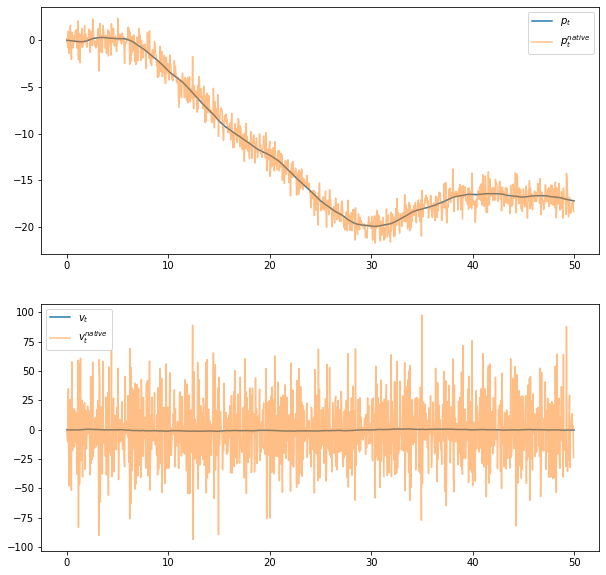

In [0]:
# your code here
v_hat_native = np.zeros(N)
for i in range(len(y[0])):
  if i == 0:
    v_hat_native[i] = 0
  else:
    v_hat_native[i] = (y[0][i] - y[0][i-1]) / delt

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(ts, x[0,:], label='$p_t$')
plt.plot(ts[:-1], y[0,:], alpha=0.5, label='$p^{native}_t$')
plt.legend()

plt.subplot(212)
plt.plot(ts, x[1,:], label='$v_t$')
plt.plot(ts[:-1], v_hat_native, alpha=0.5, label='$v^{native}_t$')
plt.legend()

plt.show()

**(Problem 2)** Since the above estimates look severely corrupted by shigh frequency noise components, we would like to use low pass filters to smooth them out. Though there are sophisticated ways of designing and implementing the discrete-time low pass filters, we would go with a simle first-order recursive form described below. The low-pas-filtered signal $\hat{p}^{\text{lpf}}_t$ for the naive estimate $\hat{p}^{\text{naive}}_t$ is given by 

<br>

$$
\hat{p}^{\text{lpf}}_{t+1} = a  \hat{p}^{\text{lpf}}_{t} + b \left(\hat{p}^{\text{naive}}_{t+1} + \hat{p}^{\text{naive}}_{t}\right) 
$$

<br>

where we will use $(a,b)=(0.9047619,0.04761905)$ for position estimates and $(a,b)=(0.99004975,0.00497512)$ for velocity estimates. The following cell computes these numbers, but you don't have to care about it.

In [0]:
import scipy.signal as sps
bw_p = 2
bw_v = 0.2
lpf_p = sps.cont2discrete(([bw_p],[1.,bw_p]), delt, method='bilinear')
lpf_v = sps.cont2discrete(([bw_v],[1.,bw_v]), delt, method='bilinear')
print(lpf_p)
print(lpf_v)

(array([[0.04761905, 0.04761905]]), array([ 1.       , -0.9047619]), 0.05)
(array([[0.00497512, 0.00497512]]), array([ 1.        , -0.99004975]), 0.05)


Using these coefficients, implement the low pass filter and compare the state estimates with the true state variables. Overlap $\hat{p}^{\text{lpf}}_t$ and ${p}_t$ on a single plot, and $\hat{v}^{\text{lpf}}_t$ and ${v}_t$ on another plot.

In [0]:
# your code here
p_hat_lpf = np.zeros(len(y[0,:]))
v_hat_lpf = np.zeros(len(v_hat_native))

for i in range(len(y[0,:])-1):
  p_hat_lpf[i+1] = -lpf_p[1][1]*p_hat_lpf[i] + lpf_p[0][0][0]*(y[0][i+1] + y[0][i])

for i in range(len(v_hat_native)-1):
  v_hat_lpf[i+1] = -lpf_v[1][1]*v_hat_lpf[i] + lpf_v[0][0][0]*(v_hat_native[i+1] + v_hat_native[i])


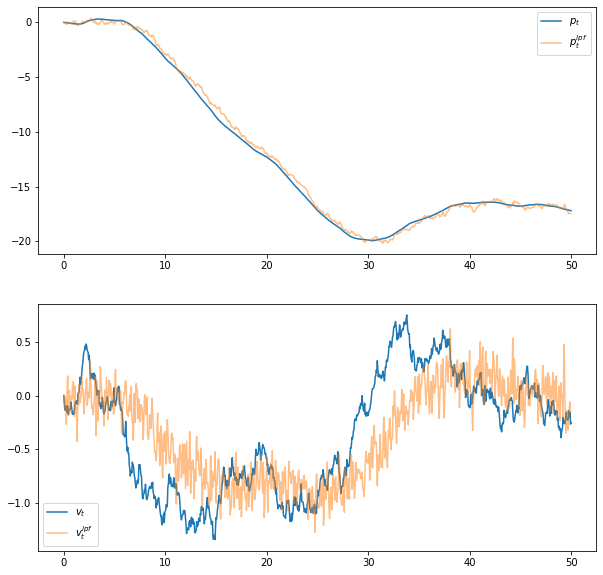

In [0]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(ts, x[0,:], label='$p_t$')
plt.plot(ts[:-1], p_hat_lpf, alpha=0.5, label='$p^{lpf}_t$')
plt.legend()

plt.subplot(212)
plt.plot(ts, x[1,:], label='$v_t$')
plt.plot(ts[:-1], v_hat_lpf, alpha=0.5, label='$v^{lpf}_t$')
plt.legend()

plt.show()

**(Problem 3)** A better (actually the best) way in short is as follows. We begin with the state estimate, $\hat{x}_t$, and the error covariance of the state variable, $\Sigma_t$, and will recursively propagate them.

<br>

\begin{align*}
  \hat{x}_t &= \mathbb{E}\left(x_t \mid y_0, y_1, \dots, y_{t-1} \right) \\
  \Sigma_t &= \mathbb{cov}\left(x_t \mid y_0, y_1, \dots, y_{t-1} \right)
\end{align*}

<br>

Here, $\hat{x}_t$ can be interpreted as the state estimate at time $t$ given observations up to time $t-1$, and ${\Sigma}_t$ is the error covariance matrix which explains the estimated accuracy of the state estimates given observations up to time $t-1$. These should be described in way more details, however we will not go into that and the above simple explanation would be sufficient for understanding elementary mechanisms of optimal state estimation. 

<br>

1) The Kalman gain is described by:

<br>

$$
  K_t = A\Sigma_tC^T \left( C\Sigma_t C^T + \Sigma_v \right)^{-1}
$$

<br>

where $\Sigma_v$ represents the covariance of the measurement noise, $n_t$. Since we assumed the IID zero mean Gaussian random noise with variance 1, we have that $\Sigma_v=I$.

<br>

2) Compute the output prediction:

<br>

$$
  \hat{y}_t = C\hat{x}_t
$$

<br>

Then the quantity $y_t-\hat{y}_t$ presents the prediction error on your output, and can be an indirect measure of your model accuracy.

<br>

3) Compute the state estimate:

<br>

$$
  \hat{x}_{t+1} = A\hat{x}_t + K_t \left(y_t-\hat{y}_t \right)
$$

<br>

The above can be interpreted as predicting the next state based on your model ($A\hat{x}_t$) and then compensating it based on the your model accuracy, $K_t \left(y_t-\hat{y}_t \right)$.

<br>

4) Update the covariance:

<br>

$$
  \Sigma_{t+1} = A\Sigma_tA^T - A\Sigma_t C^T \left(C\Sigma_t C^T + \Sigma_v \right)^{-1}C\Sigma_t A^T + \Sigma_w
$$

<br>

where $\Sigma_w$ represents the covariance of the dicturbance input, $Bw_t$. Since we assumed that $w_t$ follows the IID zero mean Gaussian random noise with variance 1, we have that $\Sigma_w=BB^T$. This procedure corresponds to conditioning the Gaussian distibution using the new measurement information via Bayesian inference, and propagating it under the affine dynamical relation.

<br>

Implement this, and compare the state estimates with the true state variables. Compare your results with the naive estimates and the low-pass-filtered estimates. You may simply assume that $\hat{x}=(0,0)$ and $\Sigma_0 = 10I$; you will notice that your solution will be robust to changes in these initial conditions.

The above procedure is called the _Kalman filtering_, and it turns out to be optimal, in other words most accurate, under some technical conditions.

In [0]:
# your code here
